In [18]:
!wget -O simhei.ttf "https://github.com/adobe-fonts/source-han-sans/raw/release/SubsetOTF/CN/SourceHanSansCN-Regular.otf"

import matplotlib.pyplot as plt
import matplotlib

matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='Source Han Sans CN') # Use the correct font family name

--2025-12-29 07:37:29--  https://github.com/adobe-fonts/source-han-sans/raw/release/SubsetOTF/CN/SourceHanSansCN-Regular.otf
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-han-sans/release/SubsetOTF/CN/SourceHanSansCN-Regular.otf [following]
--2025-12-29 07:37:29--  https://raw.githubusercontent.com/adobe-fonts/source-han-sans/release/SubsetOTF/CN/SourceHanSansCN-Regular.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8429224 (8.0M) [application/octet-stream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   8.04M  --.-KB/s    in 0.06s   

2025-12-

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ==========================================
# 1. 配置参数
# ==========================================
class Opts:
    train_dir = '/kaggle/input/ccpd-piture/train'
    val_dir = '/kaggle/input/ccpd-piture/val'
    save_dir = '/kaggle/working/weights'
    img_size = (94, 24)
    batch_size = 64         
    epochs = 80             # 训练轮数
    learning_rate = 0.001   
    lpr_max_len = 8
    dropout = 0.5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(Opts.save_dir, exist_ok=True)

# 定义两张表，分别用于解码
PROVINCES = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
ADS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# 训练时模型用的总分类数
CHARS = PROVINCES + ADS 

In [20]:
# 2. 模型定义 (STNet + LPRNet)
# ==========================================
class STNet(nn.Module):
    def __init__(self):
        super(STNet, self).__init__()
        self.localization = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=5),
            nn.MaxPool2d(3, stride=3),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(32 * 14 * 2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 32 * 14 * 2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        return x

class SmallBasicBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(SmallBasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, lpr_max_len, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        self.lpr_max_len = lpr_max_len
        self.class_num = class_num
        self.stn = STNet()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), 
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            SmallBasicBlock(ch_in=64, ch_out=128),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            SmallBasicBlock(ch_in=64, ch_out=256),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            SmallBasicBlock(ch_in=256, ch_out=256),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)), 
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1),
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=448+self.class_num, out_channels=self.class_num, kernel_size=(1, 1), stride=(1, 1)),
        )

    def forward(self, x):
        x = self.stn(x)
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            x = layer(x)
            if i in [2, 6, 13, 22]: keep_features.append(x)
        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]: f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]: f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            global_context.append(f)
        x = torch.cat(global_context, 1)
        x = self.container(x)
        logits = torch.mean(x, dim=2)
        return logits

In [21]:
# 3. 数据集 (带增强与修复)
# ==========================================
class CCPDDataSet(Dataset):
    def __init__(self, img_dir, img_size, lpr_max_len, is_train=True):
        self.img_dir = img_dir
        self.img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))]
        self.img_size = img_size
        self.lpr_max_len = lpr_max_len
        self.is_train = is_train
        
        if is_train:
            self.transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10, fill=0),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2),
            ])
        else:
            self.transform = None
        print(f"Loaded {len(self.img_paths)} images from {img_dir}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        while True:
            filename = self.img_paths[index]
            try:
                basename = os.path.basename(filename)
                splits = basename.split('-')
                box_str = splits[2]
                box_coords = box_str.split('_')
                if len(box_coords) < 4: raise ValueError("Box coords broken")
                x1, y1, x2, y2 = int(box_coords[0]), int(box_coords[1]), int(box_coords[2]), int(box_coords[3])

                plate_str = splits[4]
                label_idx = [int(i) for i in plate_str.split('_')]
                
                img = cv2.imread(filename)
                if img is None: raise ValueError("Img None")
                h, w, _ = img.shape
                
                margin = 5
                x1, y1 = max(0, x1 - margin), max(0, y1 - margin)
                x2, y2 = min(w, x2 + margin), min(h, y2 + margin)

                crop_img = img[y1:y2, x1:x2]
                crop_img = cv2.resize(crop_img, self.img_size)
                
                if self.is_train and self.transform:
                    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                    pil_img = transforms.ToPILImage()(crop_img)
                    pil_img = self.transform(pil_img)
                    crop_img = np.array(pil_img)
                
                crop_img = crop_img.astype('float32')
                crop_img -= 127.5
                crop_img *= 0.0078125
                crop_img = np.transpose(crop_img, (2, 0, 1))
                return torch.from_numpy(crop_img), torch.tensor(label_idx, dtype=torch.long), len(label_idx)
            except Exception as e:
                index = np.random.randint(0, len(self))
                continue

def collate_fn(batch):
    imgs, labels, lengths = [], [], []
    for sample in batch:
        imgs.append(sample[0])
        labels.extend(sample[1])
        lengths.append(sample[2])
    labels = np.asarray(labels).flatten().astype(np.int32)
    return (torch.stack(imgs, 0), torch.from_numpy(labels), torch.tensor(lengths))

# 贪婪解码
def greedy_decode(preds, blank_index):
    decoded_batch = []
    for sequence in preds:
        decoded_seq = []
        last_char = -1
        for char in sequence:
            char = char.item()
            if char != blank_index:
                if char != last_char: decoded_seq.append(char)
            last_char = char
        decoded_batch.append(decoded_seq)
    return decoded_batch

# === 专门用于显示的解码函数 (核心修正) ===
def decode_plate_display(indices):
    """
    将索引转换为真实车牌字符串
    逻辑：第0位查PROVINCES表，第1+位查ADS表
    """
    res = ""
    for i, idx in enumerate(indices):
        if i == 0:
            if idx < len(PROVINCES):
                res += PROVINCES[idx]
        else:
            if idx < len(ADS):
                res += ADS[idx]
    return res

Loaded 5769 images from /kaggle/input/ccpd-piture/train
Loaded 1001 images from /kaggle/input/ccpd-piture/val
开始训练... (训练完成后自动画图)


Epoch 1/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 2.2006 | Val Acc: 0.00%


Epoch 2/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 1.2268 | Val Acc: 14.39%
New Best Model Saved (Acc: 14.39%)


Epoch 3/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.6695 | Val Acc: 58.04%
New Best Model Saved (Acc: 58.04%)


Epoch 4/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.3901 | Val Acc: 61.84%
New Best Model Saved (Acc: 61.84%)


Epoch 5/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.3223 | Val Acc: 72.83%
New Best Model Saved (Acc: 72.83%)


Epoch 6/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.2834 | Val Acc: 73.13%
New Best Model Saved (Acc: 73.13%)


Epoch 7/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.2507 | Val Acc: 71.13%


Epoch 8/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.2382 | Val Acc: 66.93%


Epoch 9/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.2110 | Val Acc: 78.42%
New Best Model Saved (Acc: 78.42%)


Epoch 10/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.2009 | Val Acc: 69.03%


Epoch 11/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1895 | Val Acc: 77.82%


Epoch 12/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1943 | Val Acc: 81.52%
New Best Model Saved (Acc: 81.52%)


Epoch 13/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1731 | Val Acc: 70.73%


Epoch 14/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1843 | Val Acc: 83.12%
New Best Model Saved (Acc: 83.12%)


Epoch 15/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1842 | Val Acc: 81.82%


Epoch 16/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1520 | Val Acc: 79.92%


Epoch 17/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1423 | Val Acc: 79.22%


Epoch 18/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1390 | Val Acc: 83.32%
New Best Model Saved (Acc: 83.32%)


Epoch 19/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1287 | Val Acc: 83.52%
New Best Model Saved (Acc: 83.52%)


Epoch 20/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1265 | Val Acc: 84.22%
New Best Model Saved (Acc: 84.22%)


Epoch 21/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1240 | Val Acc: 85.21%
New Best Model Saved (Acc: 85.21%)


Epoch 22/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1220 | Val Acc: 86.31%
New Best Model Saved (Acc: 86.31%)


Epoch 23/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1152 | Val Acc: 82.52%


Epoch 24/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1192 | Val Acc: 82.42%


Epoch 25/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1082 | Val Acc: 86.51%
New Best Model Saved (Acc: 86.51%)


Epoch 26/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1051 | Val Acc: 86.91%
New Best Model Saved (Acc: 86.91%)


Epoch 27/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1119 | Val Acc: 86.31%


Epoch 28/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1030 | Val Acc: 88.51%
New Best Model Saved (Acc: 88.51%)


Epoch 29/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1006 | Val Acc: 85.21%


Epoch 30/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1006 | Val Acc: 86.21%


Epoch 31/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.1021 | Val Acc: 88.41%


Epoch 32/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0883 | Val Acc: 86.81%


Epoch 33/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0968 | Val Acc: 87.21%


Epoch 34/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0862 | Val Acc: 89.01%
New Best Model Saved (Acc: 89.01%)


Epoch 35/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0881 | Val Acc: 89.61%
New Best Model Saved (Acc: 89.61%)


Epoch 36/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0959 | Val Acc: 90.41%
New Best Model Saved (Acc: 90.41%)


Epoch 37/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0846 | Val Acc: 88.11%


Epoch 38/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0822 | Val Acc: 88.41%


Epoch 39/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0815 | Val Acc: 88.61%


Epoch 40/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0835 | Val Acc: 89.71%


Epoch 41/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0795 | Val Acc: 89.11%


Epoch 42/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0711 | Val Acc: 88.91%


Epoch 43/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0699 | Val Acc: 89.01%


Epoch 44/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0748 | Val Acc: 90.41%


Epoch 45/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0746 | Val Acc: 89.41%


Epoch 46/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0740 | Val Acc: 89.81%


Epoch 47/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0794 | Val Acc: 89.71%


Epoch 48/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0684 | Val Acc: 90.11%


Epoch 49/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0673 | Val Acc: 90.61%
New Best Model Saved (Acc: 90.61%)


Epoch 50/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0662 | Val Acc: 91.01%
New Best Model Saved (Acc: 91.01%)


Epoch 51/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0697 | Val Acc: 89.81%


Epoch 52/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0650 | Val Acc: 90.61%


Epoch 53/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0597 | Val Acc: 91.91%
New Best Model Saved (Acc: 91.91%)


Epoch 54/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0614 | Val Acc: 90.61%


Epoch 55/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0616 | Val Acc: 90.31%


Epoch 56/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0622 | Val Acc: 89.51%


Epoch 57/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0603 | Val Acc: 90.41%


Epoch 58/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0588 | Val Acc: 90.71%


Epoch 59/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0578 | Val Acc: 90.81%


Epoch 60/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0539 | Val Acc: 91.31%


Epoch 61/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0540 | Val Acc: 90.71%


Epoch 62/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0522 | Val Acc: 90.81%


Epoch 63/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0549 | Val Acc: 91.11%


Epoch 64/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0498 | Val Acc: 91.41%


Epoch 65/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0532 | Val Acc: 92.31%
New Best Model Saved (Acc: 92.31%)


Epoch 66/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0501 | Val Acc: 92.01%


Epoch 67/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0503 | Val Acc: 91.31%


Epoch 68/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0498 | Val Acc: 90.61%


Epoch 69/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0476 | Val Acc: 90.91%


Epoch 70/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0472 | Val Acc: 91.51%


Epoch 71/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0494 | Val Acc: 91.51%


Epoch 72/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0487 | Val Acc: 91.61%


Epoch 73/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0465 | Val Acc: 91.61%


Epoch 74/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0495 | Val Acc: 90.91%


Epoch 75/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0467 | Val Acc: 91.11%


Epoch 76/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0496 | Val Acc: 90.61%


Epoch 77/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0502 | Val Acc: 91.11%


Epoch 78/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0463 | Val Acc: 91.11%


Epoch 79/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0457 | Val Acc: 91.01%


Epoch 80/80:   0%|          | 0/91 [00:00<?, ?it/s]

Result -> Train Loss: 0.0467 | Val Acc: 91.01%
训练结束。正在生成可视化图表...


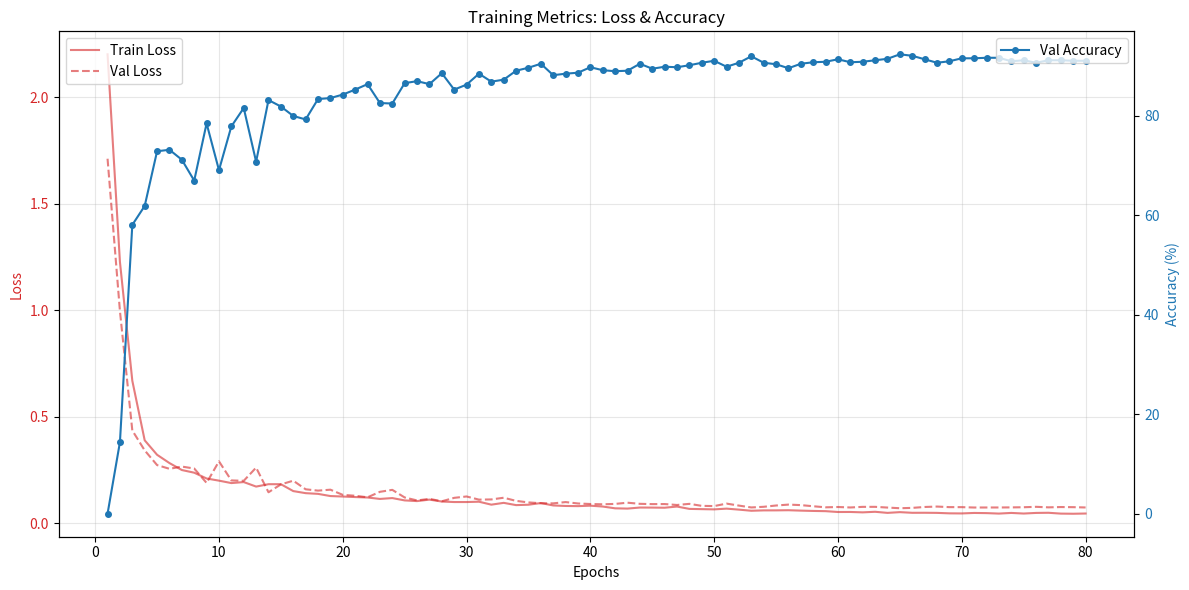

正在抽取验证集图片展示效果...


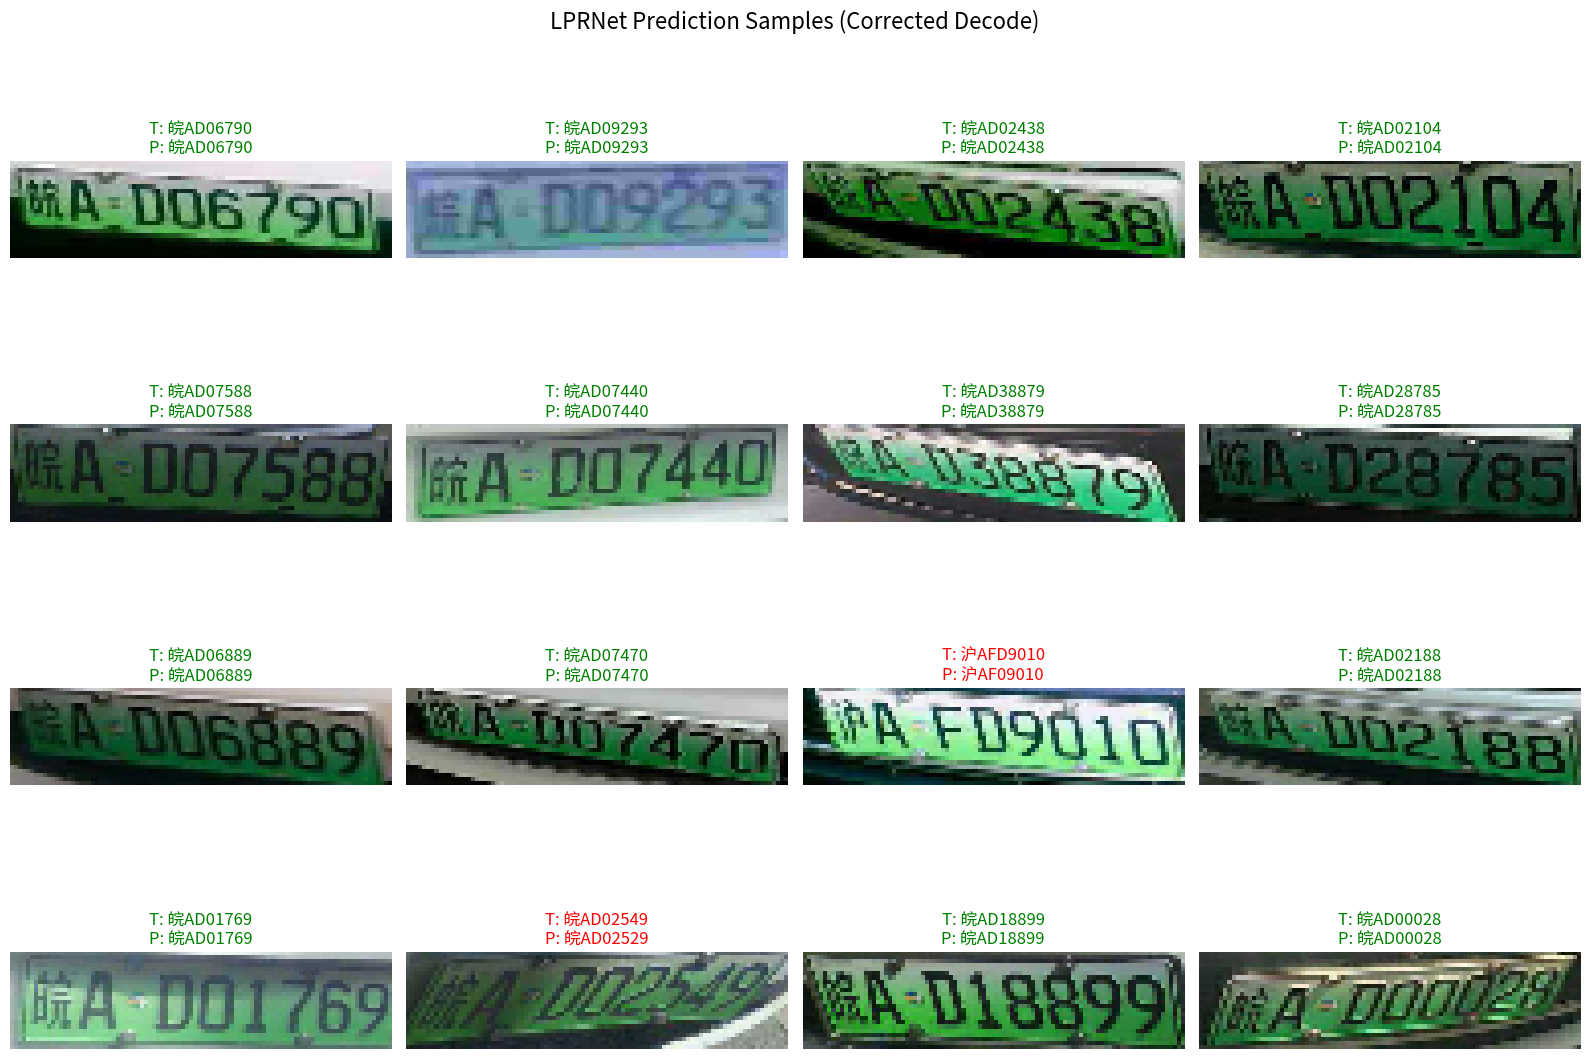

In [22]:
# 4. 主程序
# ==========================================
def main():
    train_dataset = CCPDDataSet(Opts.train_dir, Opts.img_size, Opts.lpr_max_len, is_train=True)
    val_dataset = CCPDDataSet(Opts.val_dir, Opts.img_size, Opts.lpr_max_len, is_train=False)
    
    train_loader = DataLoader(train_dataset, batch_size=Opts.batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=Opts.batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

    model = LPRNet(lpr_max_len=Opts.lpr_max_len, class_num=len(CHARS)+1, dropout_rate=Opts.dropout)
    model.to(Opts.device)
    
    optimizer = optim.Adam(model.parameters(), lr=Opts.learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Opts.epochs, eta_min=1e-6)
    ctc_loss = nn.CTCLoss(blank=len(CHARS), reduction='mean') 

    print("开始训练... (训练完成后自动画图)")
    best_acc = 0.0
    
    # 记录数据
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(Opts.epochs):
        # --- Train ---
        model.train()
        train_loss = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{Opts.epochs}')
        
        for imgs, labels, lengths in pbar:
            imgs, labels, lengths = imgs.to(Opts.device), labels.to(Opts.device), lengths.to(Opts.device)
            logits = model(imgs) 
            logits = logits.permute(2, 0, 1) 
            log_probs = logits.log_softmax(2).requires_grad_()
            input_lengths = torch.full(size=(imgs.size(0),), fill_value=logits.size(0), dtype=torch.long)
            loss = ctc_loss(log_probs, labels, input_lengths, lengths)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        scheduler.step()
        avg_train_loss = train_loss / len(train_loader)

        # --- Val (计算准确率) ---
        model.eval()
        val_loss, correct_count, total_count = 0, 0, 0
        with torch.no_grad():
            for imgs, labels, lengths in val_loader:
                imgs, labels = imgs.to(Opts.device), labels.to(Opts.device)
                logits = model(imgs) 
                logits_permuted = logits.permute(2, 0, 1)
                log_probs = logits_permuted.log_softmax(2)
                input_lengths = torch.full(size=(imgs.size(0),), fill_value=logits_permuted.size(0), dtype=torch.long)
                loss = ctc_loss(log_probs, labels, input_lengths, lengths)
                val_loss += loss.item()
                preds = logits.permute(0, 2, 1).argmax(dim=2) 
                decoded_preds = greedy_decode(preds, blank_index=len(CHARS))
                
                # 还原真实标签
                start = 0
                label_batch = []
                for length in lengths:
                    end = start + length
                    label_batch.append(labels[start:end].cpu().tolist())
                    start = end
                
                # 验证准确率逻辑：
                # 在计算准确率时，只要索引列表一致即可，不需要转换成字符串
                for pred, target in zip(decoded_preds, label_batch):
                    if pred == target: correct_count += 1
                total_count += imgs.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        current_acc = correct_count / total_count if total_count > 0 else 0
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(current_acc * 100)

        print(f"Result -> Train Loss: {avg_train_loss:.4f} | Val Acc: {current_acc:.2%}")

        if current_acc > best_acc:
            best_acc = current_acc
            torch.save(model.state_dict(), os.path.join(Opts.save_dir, 'lprnet_best.pth'))
            print(f"New Best Model Saved (Acc: {current_acc:.2%})")

    print("训练结束。正在生成可视化图表...")

    # ==========================================
    # 5. 自动可视化
    # ==========================================
    
    # --- 曲线图 ---
    epochs_range = range(1, Opts.epochs + 1)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs_range, history['train_loss'], color=color, label='Train Loss', alpha=0.6)
    ax1.plot(epochs_range, history['val_loss'], color=color, linestyle='--', label='Val Loss', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(epochs_range, history['val_acc'], color=color, marker='o', markersize=4, label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Training Metrics: Loss & Accuracy')
    plt.tight_layout()
    plt.show()

    # --- 预测效果展示 (应用修正后的解码逻辑) ---
    print("正在抽取验证集图片展示效果...")
    
    # 加载最佳模型
    best_model = LPRNet(lpr_max_len=Opts.lpr_max_len, class_num=len(CHARS)+1, dropout_rate=0)
    best_model.load_state_dict(torch.load(os.path.join(Opts.save_dir, 'lprnet_best.pth')))
    best_model.to(Opts.device)
    best_model.eval()

    visual_indices = np.random.choice(len(val_dataset), 16, replace=False)
    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle('LPRNet Prediction Samples (Corrected Decode)', fontsize=16)

    with torch.no_grad():
        for i, idx in enumerate(visual_indices):
            img_tensor, label_idx, _ = val_dataset[idx]
            img_input = img_tensor.unsqueeze(0).to(Opts.device)
            
            logits = best_model(img_input)
            preds = logits.permute(0, 2, 1).argmax(dim=2)
            
            # 获取去重后的索引序列
            pred_indices = greedy_decode(preds, blank_index=len(CHARS))[0]
            true_indices = label_idx.tolist()
            
            # 使用修正函数将索引转为字符串 (省份+字母)
            pred_str = decode_plate_display(pred_indices)
            true_str = decode_plate_display(true_indices)
            
            img_show = img_tensor.cpu().numpy().transpose(1, 2, 0)
            img_show = (img_show * 128 + 127.5).astype(np.uint8)
            img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
            
            ax = axes[i // 4, i % 4]
            ax.imshow(img_show)
            color = 'green' if pred_str == true_str else 'red'
            # 字体调大，方便看
            ax.set_title(f"T: {true_str}\nP: {pred_str}", color=color, fontsize=12, fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()